In [31]:
#!pip install torchviz
#!pip install icecream

# Import

In [32]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F  # F.mse_loss
import torch.optim as optim
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import TensorDataset, DataLoader  # for batch and split Xtrain Ytrain dataset
import sys
import torchviz
import scipy
import scipy.ndimage as nd
from scipy.stats import norm
from scipy.optimize import minimize

from locale import format
from dataclasses import dataclass, MISSING

import seaborn as sns
import plotly.graph_objects as go


from scipy.interpolate import griddata
from scipy import special
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
# from scipy.sparse import identity
from icecream import ic  # for debugging. print variable name

## !!!!! To get the parameters
#from gdrive.MyDrive.Github.PredictiveCoding.main.Src.PC_param import default_parameters_network

#from PC_param import default_parameters_network
#import PC_param.ipynb
#from PC_Parameters import default_parameters_network

## !!!!! To get the parameters
import sys
#sys.path.insert(1, '/Users/knzga/Documents/folder/02_Computational Neuroscience Project/Programming/VScode/PredictiveCoding/main/Src/PC_param.ipynb')
sys.path.insert(1, '/main/CustomPackages/PC_param.ipynb')
#https://github.com/Nozasp/PredictiveCoding/blob/main/
#main/Src

#C:\Users\knzga\Documents\02_Computational Neuroscience Project\Programming\VScode\PredictiveCoding\main\Src> 
#from PC_param import default_parameters_network #from PC_param 
from PC_Parameters import default_parameters_network

pars = default_parameters_network()


# Function

In [33]:

#### 2- Input/Output function

def plot_io(x, y, sign):
    if sign == "+":
        sign_name = 'Excitatory'
        label = "ae={0}, be={1}, hme={2}"
        a, b, hm = pars['ae'], pars['be'], pars['hme']
        color = "k"
    elif sign == "-":
        sign_name = 'Inhibitory'
        label = "ai={0}, bi={1}, hmi={2}"
        a, b, hm = pars['ai'], pars['bi'], pars['hmi']
        color = "r"

    plt.plot(x, y, color, label=label.format(a, b, hm))

    plt.xlabel("Input values - nA")
    plt.ylabel("Spike Frequency - Hz")
    plt.xlim([-0.01, 1])
    plt.title("Input-output function")
    # plt.title("{0} Input-output function".format(sign_name))
    plt.legend()


def plot_r(range_sim, r_e, r_i, param, xlim_ar=None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"  # , I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"  # , I2={2}"
    plt.plot(range_sim, r_e, "r", label=label_e.format(param.Jee, param.Jei))  # , param.I1 #, param.In
    plt.plot(range_sim, r_i, "orange", label=label_i.format(param.Jii, param.Jie))  # , round(param.I2, 2)))

    plt.xlabel("Time - ms")
    plt.ylabel("Spike Frequency - Hz")
    if xlim_ar != None:
        plt.xlim(xlim_ar)  # [0, .1]
    plt.title("Firing rate of the NMDA and GABA populations")
    plt.legend()


def plot_s(range_sim, S_e, S_i, param, xlim_ar=None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"  # , I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"  # , I2={2}"
    plt.plot(range_sim, S_e, "olive", label=label_e.format(param.Jee, param.Jei))  # , param.I1
    plt.plot(range_sim, S_i, "green", label=label_i.format(param.Jii, param.Jie))  # , round(param.I2, 2)
    if xlim_ar != None:
        plt.xlim(xlim_ar)
    plt.xlabel("Time - ms")
    plt.ylabel("Open channel")
    # plt.xlim([0, .1])
    plt.title("Average open channel for the NMDA and GABA populations")
    plt.legend()


# 2- Plot HeatMap of firing rate function
def HeatMap(rE, rI, J=None):
    if J == None:
        J = [.00989, 0.0081, .1, .87, .00081]  # J = dict(Jin=.008, Jee= .2, Jie=.2, Jei=1.4, Jii=6.7)
    if type(J) == dict:
        J = np.array(list(J.values()))

    rE_df = pd.DataFrame(rE.T)  # to get time vs pop
    rI_df = pd.DataFrame(rI.T)
    rE_df.index = rE_df.index + 1
    rI_df.index = rI_df.index + 1
    rE_df.index.name, rI_df.index.name = ["Excitatory Population", "Inhibitory Population"]
    rE_df.columns.name, rI_df.columns.name = ["Time s", "Time s"]
    # print(rE_df.loc[[10]])

    # set context for the upcoming plot
    sns.set_context("notebook", font_scale=.8, rc={"lines.linewidth": 2.5, 'font.family': 'Helvetica'})

    fig, (axA, axB) = plt.subplots(2, 1, figsize=(6, 6))

    sns.heatmap(rE_df, ax=axA, cmap="viridis")
    sns.heatmap(rI_df, ax=axB)
    axA.set_title(f"Firing rate in Hz of exc populations over time. Jie: {J[2]}, Jee: {J[1]}, Jin: {J[0]}",
                  fontdict={"fontsize": 10})
    axB.set_title(f"Firing rate in Hz of inh populations over time. Jei: {J[3]}, Jii: {J[4]}",
                  fontdict={"fontsize": 10})
    plt.tight_layout()

    plt.show()


# Filters gauss and Dog and LoG
def gaussian_filter(s, N):
    k = np.arange(1, N + 1)
    n = 1 / (np.sqrt(2 * np.pi) * N * s)
    gaussW = n * np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * s ** 2))
    gaussW2 = gaussW / (.009 ** 2 / np.max(gaussW))  # 1
    return gaussW2


def dog_filter(sOut, N):
    sIn = sOut / 30
    k = np.arange(1, N + 1)
    gaussIn = np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * sIn ** 2))
    gaussOut = np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * sOut ** 2))
    dog = gaussOut - gaussIn
    if np.max(dog) == 0 or None:
        print('zero max')
        dog = 0
    else:
        dog = dog / (.042 ** 2 / np.max(dog))  # .0088
    return dog


def LoG_filter(s, N):
    x_lap = np.eye(N)
    lapl_filter = nd.gaussian_laplace(x_lap, sigma=(s, s))
    return lapl_filter


def dLogGaus(s=.61, N=20):
    dig = LoG_filter(s, N) + gaussian_filter(.019 * s, N)
    return dig


"""### Differentiable function for back propagation

To avoid non-differentiable araising from discontinuity of the function, I "relax" (smoothen) the where() expression by using a sigmoid instead
*   with grad_fn:
*   if I get : > <SumBackward1 object at 0x7f79da0b9520> # differentiable
*   else I get none
"""


def relu_stim(x, stim):
    return torch.nn.functional.relu(1.0 - torch.abs(x - stim),
                                    inplace=False)  # inplace = False to avoid implace operation




def Dirac(A, N=pars["NumN"]):
    y = scipy.signal.unit_impulse(N, idx=(torch.max(torch.argmax(A))))  # , dtype= <class 'float'>)
    return torch.tensor(y)



"""### Try Normalization to "make it proba"
"""


def make_it_proba(r_e):
    """sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0], 1)
    prob_r = torch.div(r_e, sum_r_e)
    print(prob_r.grad_fn)
    prob_r[prob_r != prob_r] = 0.05"""  # to replace nan to 1/20 - to sum to 1
    # print("should sum to 1:", torch.sum(prob_r, 1)) #to check that it worked
    baseline = 1
    sum_r_e_and_baseline = torch.sum(r_e, 1).reshape(r_e.shape[0], 1) + baseline
    prob_r = torch.div(r_e + baseline, sum_r_e_and_baseline)

    return prob_r.reshape(r_e.shape[0], r_e.shape[1])  # log or not log?


def make_it_proba_1d(r_e):
    baseline = 1
    sum_r_e = torch.sum(r_e) + baseline
    prob_r = torch.div(r_e +baseline, sum_r_e)  # torch.transpose(r_e, dim0=0 ,dim1=1) poses a problem
    #prob_r[prob_r != prob_r] = 0.05  # to replace nan to 1/20 - to sum to 1
    print("should sum to 1:", torch.sum(prob_r)) #to check that it worked

    return prob_r


def log_proba(proba_r):
    return torch.log(proba_r)


"""### Try softmax to "make it proba"
"""


def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), axis=1, keepdims=True)

def softmax1D(x):
    return torch.exp(x) / torch.sum(torch.exp(x))

"""### Get the expected stimuli : matrix of 1 where stimuli 0 elsewhere"""


# find the stimuli for every X = stim dataset
# find the stimuli for every X = stim dataset
def get_stimuli_input(X_train_tensor):  # input of the shape Xtrain_tensor[5,:,:]
    Xargmax = torch.argmax(X_train_tensor, dim=1)
    Xmax = torch.max(Xargmax)
    return Xmax

def get_stimuli_input1D(X_train_tensor):  # input of the shape Xtrain_tensor[5,:,:]
    Xargmax = torch.argmax(X_train_tensor)#, dim=1)
    Xmax = torch.max(Xargmax)
    return Xmax


# replace where function by relu functio which is differentiable
def get_expected_Y_relu(X_train_tensor):
    x_t = torch.transpose(X_train_tensor, 0, 1)
    dirac_2d = torch.zeros(x_t.shape)
    stim = get_stimuli_input(
        X_train_tensor)  # input of the shape Xtrain_tensor[5,:,:] # here get_stimuli not differenciable

    for pop, t in enumerate(x_t):
        tpop = torch.tensor(pop)
        dirac_2d[pop, :] = torch.nn.functional.relu(1.0 - torch.abs(tpop - stim), inplace=False).requires_grad_(False)
    dirac_2d = torch.transpose(dirac_2d, 1, 0)
    return dirac_2d


def get_expected_Y_relu_1d_where(X_train_tensor):
    stim = get_stimuli_input1D(X_train_tensor)
    dirac_1d = torch.zeros(X_train_tensor.shape)
    # Calculate the difference between tpop and stim
    for pop in enumerate(X_train_tensor):
        dirac_1d[pop[0]] = torch.where(pop[0] == torch.tensor(stim), torch.tensor(1.0), torch.tensor(0.0)).requires_grad_(False)#true #not differenciable
    return dirac_1d



# Classes

## Simple Classes

In [34]:




"""
*
*
***********  CLASS
*
*
"""


# ***************** CLASS ***************************************

@dataclass
class Parameter:
    # °°° Load the parameters °°°

    taue: float = pars["taue"]
    ae: float = pars['ae']
    be, hme, I_noise = pars['be'], pars['hme'], pars['I_noise']
    Jee: float = pars['Jee']
    taui, ai, bi, hmi = pars['taui'], pars['ai'], pars['bi'], pars['hmi']
    Jii: float = pars['Jii']
    Jei: float = pars['Jei']
    Jie: float = pars['Jie']
    Jes, Jsi = pars['Jes'], pars['Jsi']
    Jiq: float = pars['Jiq']  # 0.85; #nA
    Jin: float = pars['Jin']
    tauNMDA, tauAMPA, tauGABA = pars['tauNMDA'], pars['tauAMPA'], pars['tauGABA']
    gamma: float = pars['gamma']  # nmda coupling parameter from brunel
    c_dash = pars['c_dash']
    sigma = pars['sigma']  # param.sigma = .0007 for Noise
    I_noise = pars['sigma'] * np.random.randn(3, 1)
    I1 = pars['Jext'] * pars['mu0'] * (1 + pars['c_dash'] / 100)
    I2 = pars['Jext'] * pars['mu0'] * (1 - pars['c_dash'] / 100)
    # I1, I2 = pars['I1'], pars['I2']

    sigmaIn = pars['sigmaIn']

    # Input parameters
    In0 = pars['In0']  # % Spontaneous firing rate of input populations (Hz)
    InMax = pars['InMax']  # % Max firing rate of input populations (Hz)
    Iq0 = pars['Iq0']  # % Spontaneous firing rate of feedback populations (Hz)
    IqMax = pars['IqMax']  # % Max firing rate of feedback populations (Hz)

    # Gaussian filter
    # sIn = pars['sigmaInh'][0]
    # sOut = pars['sigmaInh'][1]

    def __init__(self, sEI, sIn, sOut, N):  # sEI=4, sIn=.2, sOut=1.2,
        # Weights (from gaussian filter)
        self.N = N  # pars['NumN']
        self.wei = torch.tensor(dog_filter(sOut, int(N)), dtype=torch.float32)   # .astype( torch.float32))  # , dtype='float64'# fun.dLogGaus(.61, N)  #fun.dog_filter(sIn, sOut, N)#gaussian_filter(sEI, N)
        self.wii = torch.tensor(np.eye(int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(sEI, int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(N)), dtype=torch.float32)  #.astype(torch.float32))  # Identity matrix
        self.f = np.arange(1, N + 1)
        self.sEI = sEI
        self.sIn = sIn
        self.sOut = sOut

    def reset(self):  # https://stackoverflow.com/questions/56878667/setting-default-values-in-a-class

        for name, field in self.__dataclass_fields__.items():
            if field.default != MISSING:
                setattr(self, name, field.default)
            else:
                setattr(self, name, field.default_factory())


# °°° Time of the simulation °°°
class Simulation:
    def __init__(self, dt, T):
        self.dt = dt
        self.T = T
        self.range_t = (np.arange(0, self.T, self.dt))
        self.Lt = self.range_t.size

    def printSim(self):
        print("T time step of the simulation (dt): ", self.dt, "  Duration of simulation S (T): ", self.T,
              "Length of the time frame (Lt): ", self.Lt)


#  °°° Initialisation of the variables °°°

class Stim:
    def __init__(self, param, simu, f, ISI=1, dur=0.2):  # 8 #[10]
        self.f = f  # array of frequency stimulus types
        self.ISI = ISI  # inter-stimulus interval
        self.dur = dur  # duration in s of a specific stimulus segment . The time the frequency fi ll be maintained in the f array
        self.tail = 0
        self.predDt = 0
        self.pred = 0
        self.InMax = param.InMax
        self.In0 = param.In0

        # Instantaneous frequency
        f_instant = np.zeros((int(self.ISI / simu.dt) + 1, 1))  # size ISI : 1 /dt : 1000

        for fx in self.f:
            fx_array = np.concatenate((np.ones((int(self.dur / simu.dt), 1)) * fx,
                                       # just 1 frequency of 8 . # inter-stim interval is aslong as stim interval
                                       np.zeros((int(self.ISI / simu.dt),
                                                 1))))  # so I get 1 list with 1000 lists containing 8 and 1000 lists containing 0
        f_stim = np.vstack((f_instant, fx_array))  # stack vertically these arrays # [0] *1000 , [8]*1000, [0]*1000
        self.f_stim = f_stim[1:]  # 1400*1

    # bottom up sensory Input # duration 1sec
    def sensoryInput(self, parameter, simu, sigmaIn=None, paramf=None, f_stim=None, InMax=None, In0=None):
        # paramf = np.arange(1, 101)
        w = np.exp(-(((paramf or parameter.f) - (f_stim or self.f_stim)) ** 2) / (
                2 * (sigmaIn or parameter.sigmaIn) ** 2))  # pars['f'] = 1:N

        # totalAct = w.sum(axis = 1) #sum over each row
        # norm_w = (w.T / totalAct).T # elementwise division
        In = np.where(f_stim or self.f_stim > 0, (InMax or self.InMax) * w + (In0 or self.In0),
                      0)  # if stim >0 give InMax * weight + In0 otherwise give 0
        if self.tail != 0:
            tail_zeros = np.zeros((parameter.N, int(self.tail / simu.dt)))
            In = np.hstack((In, tail_zeros))

        range_sim = np.arange(1, In.shape[0] + 1)
        self.In = In
        self.w = w
        self.sigmaIn = sigmaIn

        return In, range_sim, w, sigmaIn

    def printStim(self):
        print("frequence of stimulus f:", self.f, "  ISI:", self.ISI, " Size In:", self.In.shape, "Size w:",
              self.w.shape, "  f_stim:", self.f_stim.shape,
              "sigmaIn:", self.sigmaIn)




## Class Model

In [83]:
"""
*
*
***********  CLASS MYMODEL
*
*
"""


class MyModel_time(nn.Module):
    def __init__(self):
        super(MyModel_time, self).__init__()

        #--- Define other model parameters, layers, or components here if needed
        self.dt = torch.tensor(1e-4) #sim.dt
        self.N = 20
        self.taue = self.taui = torch.tensor(0.005)
         # ¤ parameter of the phi function Not tweakable parameters
        self.ae = torch.tensor(18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton
        self.be = torch.tensor(-5.38)  # Threshold of the E populaiton
        self.hme = torch.tensor(78.67)
        self.ai = torch.tensor(21.97)
        self.bi = torch.tensor(-4.81)
        self.hmi = torch.tensor(125.62)
        #create the smallest possible number
        self.epsilon = sys.float_info.epsilon

        self.sIn = .1 #torch.tensor(.1)
        self.sOut= 3.
        self.sEI = .2
        self.tauAMPA = torch.tensor(0.002)
        self.tauGABA = torch.tensor(0.005)

        self.wei = torch.tensor(dog_filter(self.sOut, int(self.N)), dtype=torch.float32)
        self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(self.sEI, int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  # Identity matrix

        # initial parameters
        self.Jee = nn.Parameter(torch.tensor(0.072, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.004, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.05, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.6, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.00695, requires_grad= True, dtype=torch.float64))

        # parameters after first training
        """self.Jee = nn.Parameter(torch.tensor(0.072, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.0042, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.05, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.6, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.0077, requires_grad= True, dtype=torch.float64))
        """

        # parameters after second training
        """
        self.Jee = nn.Parameter(torch.tensor(0.072, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.0025, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.049, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.6, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.008, requires_grad= True, dtype=torch.float64))
        """

        #parameter random to test the optimization function
        """
        self.Jee = nn.Parameter(torch.tensor(0.078, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.0035, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.051, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.4, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.006, requires_grad= True, dtype=torch.float64))"""

    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
        #multi= torch.nan_to_num((torch.mul(a, I_tot) + b), nan = self.epsilon, posinf=140, neginf=self.epsilon)
        for i in range(I_tot.shape[0]):
                if torch.isnan(I_tot[i])== True:
                    ic(I_tot, i)
                    quit()
                    sys.exit() #sys.

        mulAandI =torch.mul(a, I_tot)
        multiB= mulAandI + b
        expo = torch.exp(- (multiB))  #.abs()+ self.epsilon)
        return torch.multiply(hm, torch.divide(1, (1+ expo)))

    def forward(self, In):
        #--- Initialize model variables here
        prev_r_e = torch.zeros((In.shape[0], self.N)) # torch.ones(self.N) shows more obvious results
        prev_r_i = torch.zeros((In.shape[0], self.N))
        prev_s_ampa = torch.zeros((In.shape[0], self.N))
        prev_s_gaba = torch.zeros((In.shape[0], self.N))
        dr_e_dt = torch.zeros((In.shape[0], self.N))
        dr_i_dt = torch.zeros((In.shape[0], self.N))
        s_ampa = torch.tensor(0.)
        i_tot_e = torch.tensor(0.)
        i_tot_i = torch.tensor(0.)

        for k in range(1, In.shape[0]):
            #--- Compute values of interest
            #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
            s_gaba_wie = prev_s_gaba[k-1,:] @ self.wie
            s_ampa_wei = prev_s_ampa[k-1,:] @ self.wei
            s_gaba_wii = prev_s_gaba[k-1,:] @ self.wii
            JeeAmpa =  torch.mul(self.Jee, s_ampa)
            i_tot_e = torch.add(torch.subtract(JeeAmpa, torch.mul(self.Jie, s_gaba_wie)), torch.mul(self.Jin, In[k - 1, :]))
            i_tot_i = torch.subtract(torch.mul(self.Jei, s_ampa_wei), torch.mul(self.Jii, s_gaba_wii))

            phi_arr_e = self.phi(i_tot_e, self.ae, self.be, self.hme)
            phi_arr_i = self.phi(i_tot_i, self.ai, self.bi, self.hmi)

            dr_e_dt[k,:] = (-prev_r_e[k - 1, :] + phi_arr_e) / self.taue
            dr_i_dt[k,:] = (-prev_r_i[k - 1, :] + phi_arr_i) / self.taui

            r_e = prev_r_e[k - 1, :] + dr_e_dt[k,:] * self.dt
            r_i = prev_r_i[k - 1, :] + dr_i_dt[k,:] * self.dt

            dS_amp_dt = (- prev_s_ampa[k - 1, :] / self.tauAMPA) + r_e
            s_ampa = prev_s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- prev_s_gaba[k - 1, :] / self.tauGABA) + r_i
            s_gaba = prev_s_gaba[k - 1, :] + dS_gab_dt * self.dt

            prev_r_e[k,:] = r_e
            prev_r_i[k,:] = r_i
            prev_s_ampa[k,:] = s_ampa
            prev_s_gaba[k,:] = s_gaba


            """dr_e_dt = torch.div(torch.add(torch.neg(prev_r_e[k-1,:]), phi_arr_e), self.taue)
            dr_i_dt = torch.div(torch.add(torch.neg(prev_r_i[k-1,:]), phi_arr_i), self.taui)
            #ic(dr_e_dt.grad_fn)

            r_e = torch.mul(torch.add(torch.neg(prev_r_e[k-1,:]), dr_e_dt), self.dt)# torch.multiply(), self.newfactor)
            #ic(r_e.grad_fn, r_e.shape)
            r_i = torch.mul(torch.add(torch.neg(prev_r_i[k-1,:]), dr_i_dt), self.dt)


            dS_amp_dt = torch.add(torch.divide(- prev_s_ampa[k-1,:], self.tauAMPA), r_e)
            s_ampa = torch.mul(torch.add(prev_s_ampa[k-1,:], dS_amp_dt), self.dt)
            #ic(dS_amp_dt.grad_fn, s_ampa.grad_fn)
            dS_gab_dt = torch.add(torch.divide(- prev_s_gaba[k-1,:], self.tauGABA), r_i)
            s_gaba = torch.mul(torch.add(prev_s_gaba[k-1,:], dS_gab_dt), self.dt)"""


        return prev_r_e, prev_r_i, dr_e_dt, dr_i_dt




# Create stimuli Input

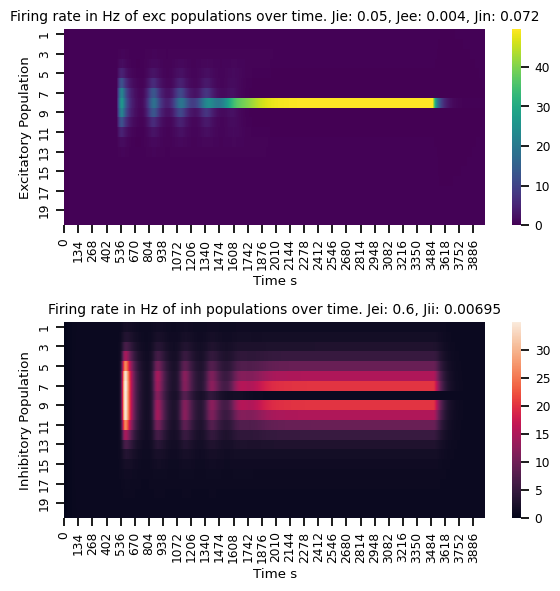

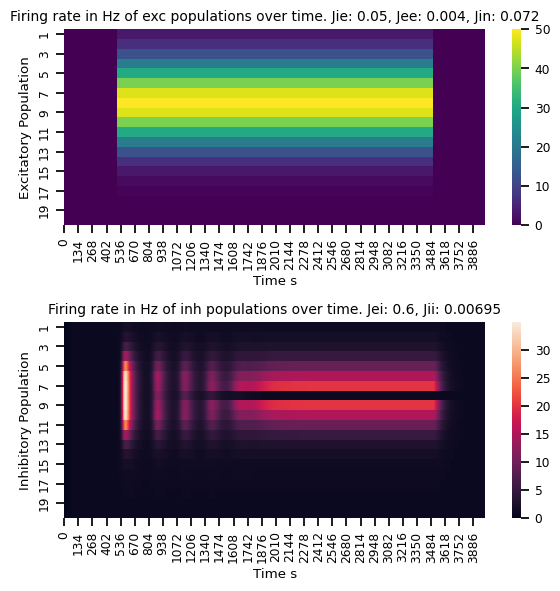

In [90]:
"""
*
*  Creat IN and Forward pass
*
*
"""


    ## Parameters used to create In
N = 20
# \\\\\\\\\\\ Parameters
param = Parameter(N=20, sIn=.1, sOut=3., sEI=.2)
# \\\\\\\\\\\ Simulation time
simu = Simulation(1e-4, .4)  # dt #rangeSim #dur = 2s

# \\\\\\\\\\\ Bottom up sensory input
stimuli = Stim(param, simu, dur=.3, f=[8], ISI=.05)  # dur = 1s Isi=1s
In, range_sim, w, sigmaIn = stimuli.sensoryInput(param, simu, sigmaIn=3.)#2.

#J1 = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}

# +++++++++++++++++++++++++ Initialize the Model ++++++++++++++++++++++++++++
mymodel = MyModel_time()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sti = torch.tensor(In, dtype=torch.float32)
r_e, r_i, dredt, dridt = mymodel.forward(sti)

J1 = {'Jee': mymodel.Jee.detach().numpy(), 'Jei': mymodel.Jei.detach().numpy(), 'Jie': mymodel.Jie.detach().numpy(), 'Jii': mymodel.Jii.detach().numpy(),
       'Jin': mymodel.Jin.detach().numpy()}
J_list = list(J1.keys())
#print(torch.max(r_e[1000,:]))
HeatMap(r_e.detach().numpy(), r_i.detach().numpy(), J1)
HeatMap(sti.detach().numpy(), r_i.detach().numpy(), J1)

'\nplt.plot(np.arange(0, r_e.shape[1]), make_it_proba(r_e)[800,:].detach().numpy(), label = "Excitatory neurons")\nplt.plot(np.arange(0, r_i.shape[1]), make_it_proba(r_i)[800,:].detach().numpy(), label = "Inhibitory neurons")\nplt.title("Neurons activity at position 11 for a stimuli of 9")\nplt.xlabel("time ms")\nplt.ylabel("Proba of Firing rate")\nplt.legend()'

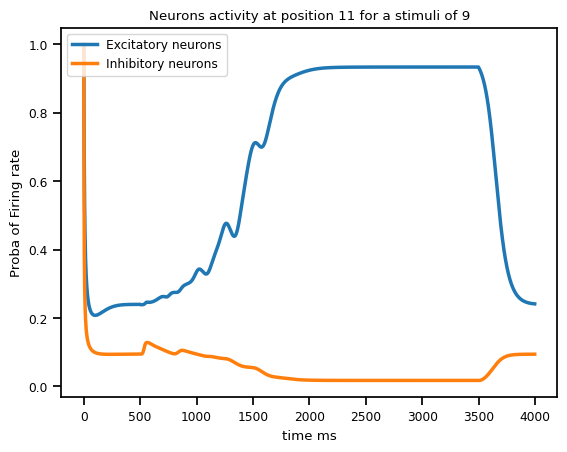

In [91]:
plt.plot(np.arange(0, r_e.shape[0]), make_it_proba(r_e)[:,7].detach().numpy(), label = "Excitatory neurons")
plt.plot(np.arange(0, r_i.shape[0]), make_it_proba(r_i)[:,7].detach().numpy(), label = "Inhibitory neurons")
plt.title("Neurons activity at position 11 for a stimuli of 9")
plt.xlabel("time ms")
plt.ylabel("Proba of Firing rate")
plt.legend()
"""
plt.plot(np.arange(0, r_e.shape[1]), make_it_proba(r_e)[800,:].detach().numpy(), label = "Excitatory neurons")
plt.plot(np.arange(0, r_i.shape[1]), make_it_proba(r_i)[800,:].detach().numpy(), label = "Inhibitory neurons")
plt.title("Neurons activity at position 11 for a stimuli of 9")
plt.xlabel("time ms")
plt.ylabel("Proba of Firing rate")
plt.legend()"""

# Optimization part

### Space for Loss design

In [92]:
def custom_loss_(re, Target, derivativeE, derivativeI):
  Cost = torch.tensor(0.0)
  
  #1/ Proba term
  Pred = make_it_proba(re)
  loss_proba = torch.zeros((Pred.shape))
  for t in range(Pred.shape[0]):
    target_pop_long = Target.select(0,t).long() #[t,:], dtype = torch.long)
    log_pred_pop = torch.log(Pred.select(0,t)) #[t,:]#.long() #input = log(probability)
    # Calculate loss by comparing the distribution to the expected probabilities
    loss_proba[t,:] = F.nll_loss(log_pred_pop, target_pop_long)#, reduction='none')  #negative log likelihood # why reduction = none???

  ### Sum over time step
  total_loss_proba = torch.sum(loss_proba)
  #ic(total_loss_proba.grad_fn)
  
  #2/ derivative good 
  stimu_pop= torch.argmax(Target).item()
  ### for excitatory neurons # targe = -derivative other ?
  tensor_for_cost_derivative_E = derivativeE.clone() # torch.zeros((r_e.shape))
  tensor_for_cost_derivative_E[:,stimu_pop] = torch.neg(derivativeE.select(1, stimu_pop)) #we want it to be negative for the stimulated population
  ic(tensor_for_cost_derivative_E.grad_fn)
  
  ### for inhibitory neurons
  tensor_for_cost_derivative_I = derivativeI.clone() # torch.zeros((r_e.shape))
  tensor_for_cost_derivative_I = torch.neg(derivativeI)
  tensor_for_cost_derivative_I[:, stimu_pop] = torch.neg(derivativeI.select(1, stimu_pop)) #[:,stimu_pop]) #tensor_for_cost_derivativeI = [i for i in derivativeI if i not in target_arr]

  """loss_derivative = torch.add(torch.sum(torch.mean(F.softplus(tensor_for_cost_derivative_E)**2, axis = 1)), #mean over popululation #then sum over every time step
                              torch.sum(torch.mean(F.softplus(tensor_for_cost_derivative_I)**2, axis = 1)))"""
  #mean instead of sum over time step
  loss_derivative = torch.add(torch.mean(torch.mean(F.softplus(tensor_for_cost_derivative_E)**2, axis = 1)), #mean over popululation #then sum over every time step
                              torch.mean(torch.mean(F.softplus(tensor_for_cost_derivative_I)**2, axis = 1)))
  
  #3/ L2 regu term
  l2_reg_coef=0.001
  l2_reg = 0.0
  for param in mymodel.parameters():
      l2_reg += torch.sum(param**2)
  
  #4/ High value of re term
  high_activity_penalty_coef=0.01
  high_activity_penalty = torch.sum(torch.sum(re[:, stimu_pop]**2)) #torch.clamp(r_e[:, 7], max=10.0

  Cost = torch.add(loss_derivative, total_loss_proba) #loss_proba + loss_derivative
  Cost_f = Cost + (l2_reg * l2_reg_coef)
  Cost_f = Cost_f + (high_activity_penalty * high_activity_penalty_coef)
  return Cost_f


In [94]:
def custom_loss_0(re, Target, derivativeE, derivativeI):
  Pred = make_it_proba(re)
  stimu_pop= torch.argmax(Target).item()
  print(stimu_pop)
  tensor_for_cost_derivative_E = derivativeE.clone() # torch.zeros((r_e.shape))
  tensor_for_cost_derivative_I = derivativeI.clone() # torch.zeros((r_e.shape))

  loss_proba = torch.zeros((Pred.shape))
  Cost = torch.tensor(0.0)
  for t in range(Pred.shape[0]):
    #1/ Proba term
    target_pop_long = Target.select(0,t).long() #[t,:], dtype = torch.long)
    log_pred_pop = torch.log(Pred.select(0,t)) #[t,:]#.long() #input = log(probability)
    # Calculate loss by comparing the distribution to the expected probabilities
    loss_proba[t,:] = F.nll_loss(log_pred_pop, target_pop_long)#, reduction='none')  #negative log likelihood # why reduction = none???

  #sum over time step
  total_loss_proba = torch.sum(loss_proba)
  #ic(total_loss_proba.grad_fn)
  #2/ derivative good 
  # for excitatory neurons # targe = -derivative other ?
  tensor_for_cost_derivative_E[:,stimu_pop] = torch.neg(derivativeE.select(1, stimu_pop)) #we want it to be negative for the stimulated population
  #ic(tensor_for_cost_derivative_E.grad_fn)
  
  #for inhibitory neurons
  tensor_for_cost_derivative_I = torch.neg(derivativeI)
  tensor_for_cost_derivative_I[:, stimu_pop] = torch.neg(derivativeI.select(1, stimu_pop)) #[:,stimu_pop])
  #ic(tensor_for_cost_derivative_I.grad_fn)
  #tensor_for_cost_derivativeI = [i for i in derivativeI if i not in target_arr]

  """loss_derivative = torch.add(torch.sum(torch.mean(F.softplus(tensor_for_cost_derivative_E)**2, axis = 1)), #mean over popululation #then sum over every time step
                              torch.sum(torch.mean(F.softplus(tensor_for_cost_derivative_I)**2, axis = 1)))"""
  #mean instead of sum over time step
  loss_derivative = torch.add(torch.mean(torch.mean(F.softplus(tensor_for_cost_derivative_E)**2, axis = 1)), #mean over popululation #then sum over every time step
                              torch.mean(torch.mean(F.softplus(tensor_for_cost_derivative_I)**2, axis = 1)))
  
  # L2 regu term
  
  l2_reg_coef=0.001
  l2_reg = 0.0
  for param in mymodel.parameters():
      l2_reg += torch.sum((param)**2) #.item()
  
  # High value of re term
  
  high_activity_penalty_coef=0.01
  high_activity_penalty = torch.sum(re[:, stimu_pop]**2) * high_activity_penalty_coef #torch.clamp(r_e[:, 7], max=10.0
  #""""""
  Cost = torch.add(loss_derivative, total_loss_proba) #loss_proba + loss_derivative
  Cost_f = Cost + (l2_reg * l2_reg_coef)# L2 term
  Cost_f = Cost_f + high_activity_penalty * high_activity_penalty_coef
  #ic(Cost_f)
  return Cost_f


In [61]:
torch.mean(dredt, axis =0)

tensor([0.5147, 0.5098, 0.5049, 0.5000, 0.4950, 0.4906, 0.4874, 0.5169, 0.4870,
        0.4895, 0.4927, 0.4957, 0.4976, 0.4987, 0.4994, 0.5004, 0.5021, 0.5048,
        0.5087, 0.5135], grad_fn=<MeanBackward1>)

#### Visualize custom neg log likelihood loss

Text(0.5, 0.92, 'Loss function: neg log likelihood')

c:\Users\knzga\AppData\Local\Programs\Python\Python311\Lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:180: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


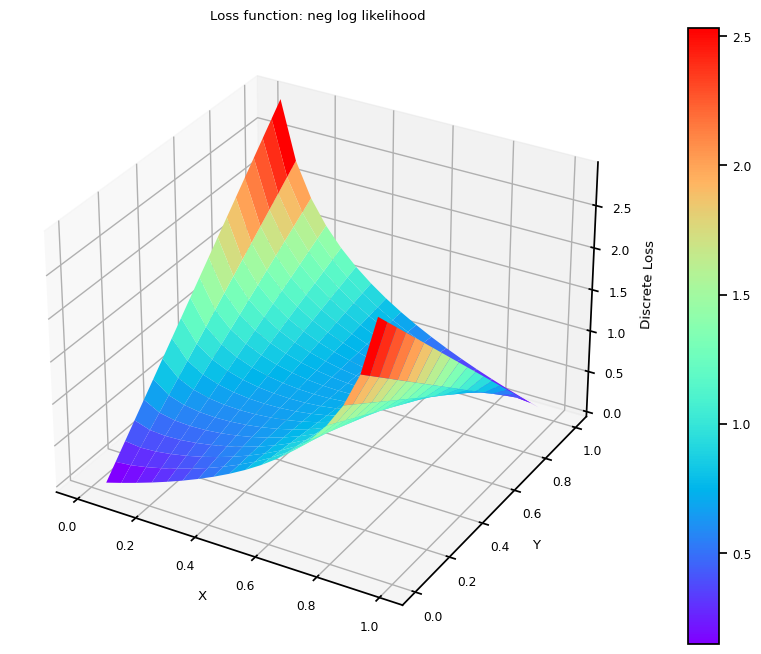

In [95]:
def softplus_np(x): return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

def custom_neg_log_likelihood(Y_prediction, Y_target):
    #https://stackoverflow.com/questions/49602205/python-numpy-negative-log-likelihood-calculation-when-some-predicted-probabiliti
    return -special.xlogy(Y_target , Y_prediction) - special.xlogy(1-Y_target, 1-Y_prediction ) + np.sum(np.mean(softplus_np(dredt.detach().numpy())**2, axis = 1)) #-Y_prediction[range(0, 20), Y_target].mean() # F.nll_loss(Y_prediction, Y_target) #(((Y_prediction - Y_target)**2))



def custom_neg_log_likelihood(Y_prediction, Y_target):
    #https://stackoverflow.com/questions/49602205/python-numpy-negative-log-likelihood-calculation-when-some-predicted-probabiliti
    return -special.xlogy(Y_target , Y_prediction) - special.xlogy(1-Y_target, 1-Y_prediction ) #-Y_prediction[range(0, 20), Y_target].mean() # F.nll_loss(Y_prediction, Y_target) #(((Y_prediction - Y_target)**2))

grid_x, grid_y = np.mgrid[0:1:20j, 0:1:20j]
#print(grid_x)
values = custom_neg_log_likelihood(grid_x, grid_y)
fig, ax = plt.subplots(nrows=1, ncols=1, num=0, figsize=(16, 8),
                       subplot_kw={'projection': '3d'})
pSurf = ax.plot_surface(grid_x, grid_y, values, rstride=1, cstride=1, cmap='rainbow')
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(x, y, z)
fig.colorbar(pSurf)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Discrete Loss')
#I have a vector y of real labels. I have a vector p of estimated probabilities.
#ax.set_title("Loss function: squared difference")
ax.set_title("Loss function: neg log likelihood")

In [63]:
# def gradientDescent
def customLoss(Prediction, Target):
    
    return customLoss


### Optimization Loop function

In [96]:


def easyLoss(Y_pred_prob,target):
    #loss = torch.sum(torch.sum((Y_prediction_prob-Y_target), axis =1))
    return torch.mean((Y_pred_prob - target)**2)

def optimizerloop(model, input, target, loss_f, Opt_name,learningRate, num_epoch):
    losses = torch.zeros(num_epoch) # used to plot the loss at the end
    
    if Opt_name == "SGD":
        optimizer = optim.SGD(model.parameters(),
                      lr=learningRate, weight_decay = 0.1)#, weight_decay = 0.00001) #, weight_decay = 0.00001)#, weight_decay = 0.001)#0.989
    elif Opt_name == "Adam":
        optimizer = optim.Adam(model.parameters(),
                      lr=learningRate)#, weight_decay = 0.00001) #, weight_decay = 0.00001)#, weight_decay = 0.001)#0.989
    
    model.train()
    for epoch in range(num_epoch):
        # Clear the gradients
        optimizer.zero_grad()

        # calculate output
        Y_prediction, I, dredt, dridt = model(input)
  
        # calculate loss
        Y_prediction_prob = make_it_proba(Y_prediction)
        #loss = torch.sum(torch.sum((Y_prediction_prob-Y_target), axis =1))# (torch.mean((Y_prediction_prob - Y_target)**2))
        #loss = loss_f(Y_prediction_prob, target) #t
        loss = loss_f(Y_prediction_prob, target , dredt, dridt)#torch.mean
        #ic(loss.grad_fn)
        loss.backward()

        optimizer.step()

        losses[epoch] = loss
        
    print(f'Epoch [{epoch + 1}/{num_epoch}], Loss: {loss}, Loss_grad: {loss.grad_fn}')  # .item()
    for i, par in enumerate(model.parameters()):
        ic(J_list[i], par, par.grad)
           

    return list(model.parameters()), losses, optimizer

In [1]:
# +++++++++++++++++++++++++ Inputs + Labels +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
X_input = sti
#Y_prediction_prob =
Y_target = get_expected_Y_relu(X_input) #get the expected dirac delta for our particular Input

#print(custom_loss_(r_e, Y_target, dredt, dridt))

NameError: name 'sti' is not defined

In [98]:
#SGD + Mean Loss
num_epochs = 10
lr = .00001

#param_new, losses_list,optimizer = optimizerloop(mymodel, X_input, Y_target, custom_loss_, "Adam",lr, num_epochs) # easyLoss #custom_loss_
param_new, losses_list,optimizer = optimizerloop(mymodel, X_input, Y_target, custom_loss_0, "Adam",lr, num_epochs) # easyLoss #custom_loss_

7
7
7
7
7
7
7
7
7
7


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0719, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(125111.6517,

Epoch [10/10], Loss: 245677.61543416927, Loss_grad: <AddBackward0 object at 0x00000268719C8D30>


 dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0039, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(57834151.3408, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0501, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-3905784.0040, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6001, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-35277.3734, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0069, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(1.9445e+08, dtype=torch.float64)


### Test new parameters optimized with new loss

In [88]:
"""
*
*
***********  CLASS MYMODEL
*
*
"""


class MyModel_newParam(nn.Module):
    def __init__(self):
        super(MyModel_newParam, self).__init__()

        #--- Define other model parameters, layers, or components here if needed
        self.dt = torch.tensor(1e-4) #sim.dt
        self.N = 20
        self.taue = self.taui = torch.tensor(0.005)
         # ¤ parameter of the phi function Not tweakable parameters
        self.ae = torch.tensor(18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton
        self.be = torch.tensor(-5.38)  # Threshold of the E populaiton
        self.hme = torch.tensor(78.67)
        self.ai = torch.tensor(21.97)
        self.bi = torch.tensor(-4.81)
        self.hmi = torch.tensor(125.62)
        #create the smallest possible number
        self.epsilon = sys.float_info.epsilon

        self.sIn = torch.tensor(.1)
        self.sOut= 3.
        self.sEI = .2
        self.tauAMPA = torch.tensor(0.002)
        self.tauGABA = torch.tensor(0.005)

        self.wei = torch.tensor(dog_filter(self.sOut, int(self.N)), dtype=torch.float32)
        self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(self.sEI, int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  # Identity matrix

        # parameters after first training        
        self.Jee = nn.Parameter(torch.tensor(0.0719, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.0039, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.0501, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.6001, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.0069, requires_grad= True, dtype=torch.float64))
  


  
        #parameter random to test the optimization function
        """
        self.Jee = nn.Parameter(torch.tensor(0.078, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.0035, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.051, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.4, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.006, requires_grad= True, dtype=torch.float64))
        """
    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
        #multi= torch.nan_to_num((torch.mul(a, I_tot) + b), nan = self.epsilon, posinf=140, neginf=self.epsilon)
        for i in range(I_tot.shape[0]):
                if torch.isnan(I_tot[i])== True:
                    ic(I_tot, i)
                    quit()
                    sys.exit() #sys.

        mulAandI =torch.mul(a, I_tot)
        multiB= mulAandI + b
        expo = torch.exp(- (multiB))  #.abs()+ self.epsilon)
        return torch.multiply(hm, torch.divide(1, (1+ expo)))

    def forward(self, In):
        #--- Initialize model variables here
        prev_r_e = torch.zeros((In.shape[0], self.N)) # torch.ones(self.N) shows more obvious results
        prev_r_i = torch.zeros((In.shape[0], self.N))
        prev_s_ampa = torch.zeros((In.shape[0], self.N))
        prev_s_gaba = torch.zeros((In.shape[0], self.N))
        dr_e_dt = torch.zeros((In.shape[0], self.N))
        dr_i_dt = torch.zeros((In.shape[0], self.N))
        s_ampa = torch.tensor(0.)
        i_tot_e = torch.tensor(0.)
        i_tot_i = torch.tensor(0.)

        for k in range(1, In.shape[0]):
            #--- Compute values of interest
            #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
            s_gaba_wie = prev_s_gaba[k-1,:] @ self.wie
            s_ampa_wei = prev_s_ampa[k-1,:] @ self.wei
            s_gaba_wii = prev_s_gaba[k-1,:] @ self.wii
            JeeAmpa =  torch.mul(self.Jee, s_ampa)
            i_tot_e = torch.add(torch.subtract(JeeAmpa, torch.mul(self.Jie, s_gaba_wie)), torch.mul(self.Jin, In[k - 1, :]))
            i_tot_i = torch.subtract(torch.mul(self.Jei, s_ampa_wei), torch.mul(self.Jii, s_gaba_wii))

            phi_arr_e = self.phi(i_tot_e, self.ae, self.be, self.hme)
            phi_arr_i = self.phi(i_tot_i, self.ai, self.bi, self.hmi)

            dr_e_dt[k,:] = (-prev_r_e[k - 1, :] + phi_arr_e) / self.taue
            dr_i_dt[k,:] = (-prev_r_i[k - 1, :] + phi_arr_i) / self.taui

            r_e = prev_r_e[k - 1, :] + dr_e_dt[k,:] * self.dt
            r_i = prev_r_i[k - 1, :] + dr_i_dt[k,:] * self.dt

            dS_amp_dt = (- prev_s_ampa[k - 1, :] / self.tauAMPA) + r_e
            s_ampa = prev_s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- prev_s_gaba[k - 1, :] / self.tauGABA) + r_i
            s_gaba = prev_s_gaba[k - 1, :] + dS_gab_dt * self.dt

            prev_r_e[k,:] = r_e
            prev_r_i[k,:] = r_i
            prev_s_ampa[k,:] = s_ampa
            prev_s_gaba[k,:] = s_gaba

        return prev_r_e, prev_r_i, dr_e_dt, dr_i_dt


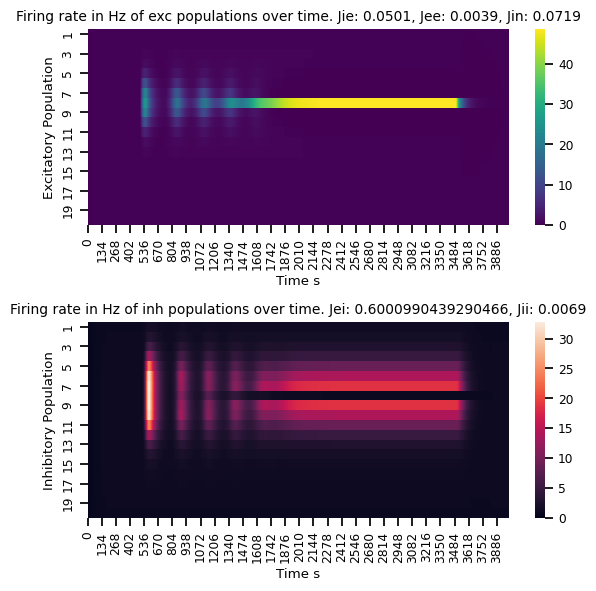

In [89]:
# call new model with other parameters

# +++++++++++++++++++++++++ Initialize the Model ++++++++++++++++++++++++++++
mymodel_newParam = MyModel_newParam()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sti = torch.tensor(stimuli.In, dtype=torch.float32)
r_e_newParam, r_i_newParam, dredt_newParam, dridt_newParam = mymodel_newParam.forward(sti)

J2 = {'Jee': mymodel_newParam.Jee.item(), 'Jei': mymodel_newParam.Jei.detach().numpy(), 'Jie': mymodel_newParam.Jie.detach().numpy(), 'Jii': mymodel.Jii.detach().numpy(),
       'Jin': mymodel_newParam.Jin.detach().numpy()}
J_list2 = list(J2.keys())
#print(torch.max(r_e[1000,:]))
HeatMap(r_e_newParam.detach().numpy(), r_i_newParam.detach().numpy(), J2)


### Can I start with other initial condition and see how it evolves 

In [69]:

"""
*
*
***********  CLASS MYMODEL
*
*
"""


class MyModel_otherInitialCondition(nn.Module):
    def __init__(self):
        super(MyModel_otherInitialCondition, self).__init__()

        #--- Define other model parameters, layers, or components here if needed
        self.dt = torch.tensor(1e-4) #sim.dt
        self.N = 20
        self.taue = self.taui = torch.tensor(0.005)
         # ¤ parameter of the phi function Not tweakable parameters
        self.ae = torch.tensor(18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton
        self.be = torch.tensor(-5.38)  # Threshold of the E populaiton
        self.hme = torch.tensor(78.67)
        self.ai = torch.tensor(21.97)
        self.bi = torch.tensor(-4.81)
        self.hmi = torch.tensor(125.62)
        #create the smallest possible number
        self.epsilon = sys.float_info.epsilon

        self.sIn = torch.tensor(.1)
        self.sOut= 3.
        self.sEI = .2
        self.tauAMPA = torch.tensor(0.002)
        self.tauGABA = torch.tensor(0.005)

        self.wei = torch.tensor(dog_filter(self.sOut, int(self.N)), dtype=torch.float32)
        self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(self.sEI, int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  # Identity matrix

       
        #parameter random to test the optimization function
        self.Jee = nn.Parameter(torch.tensor(0.078, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.0035, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.051, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.4, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.006, requires_grad= True, dtype=torch.float64))
       
    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
        #multi= torch.nan_to_num((torch.mul(a, I_tot) + b), nan = self.epsilon, posinf=140, neginf=self.epsilon)
        for i in range(I_tot.shape[0]):
                if torch.isnan(I_tot[i])== True:
                    ic(I_tot, i)
                    quit()
                    sys.exit() #sys.

        mulAandI =torch.mul(a, I_tot)
        multiB= mulAandI + b
        expo = torch.exp(- (multiB))  #.abs()+ self.epsilon)
        return torch.multiply(hm, torch.divide(1, (1+ expo)))

    def forward(self, In):
        #--- Initialize model variables here
        prev_r_e = torch.zeros((In.shape[0], self.N)) # torch.ones(self.N) shows more obvious results
        prev_r_i = torch.zeros((In.shape[0], self.N))
        prev_s_ampa = torch.zeros((In.shape[0], self.N))
        prev_s_gaba = torch.zeros((In.shape[0], self.N))
        dr_e_dt = torch.zeros((In.shape[0], self.N))
        dr_i_dt = torch.zeros((In.shape[0], self.N))
        s_ampa = torch.tensor(0.)
        i_tot_e = torch.tensor(0.)
        i_tot_i = torch.tensor(0.)

        for k in range(1, In.shape[0]):
            #--- Compute values of interest
            #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
            s_gaba_wie = prev_s_gaba[k-1,:] @ self.wie
            s_ampa_wei = prev_s_ampa[k-1,:] @ self.wei
            s_gaba_wii = prev_s_gaba[k-1,:] @ self.wii
            JeeAmpa =  torch.mul(self.Jee, s_ampa)
            i_tot_e = torch.add(torch.subtract(JeeAmpa, torch.mul(self.Jie, s_gaba_wie)), torch.mul(self.Jin, In[k - 1, :]))
            i_tot_i = torch.subtract(torch.mul(self.Jei, s_ampa_wei), torch.mul(self.Jii, s_gaba_wii))

            phi_arr_e = self.phi(i_tot_e, self.ae, self.be, self.hme)
            phi_arr_i = self.phi(i_tot_i, self.ai, self.bi, self.hmi)

            dr_e_dt[k,:] = (-prev_r_e[k - 1, :] + phi_arr_e) / self.taue
            dr_i_dt[k,:] = (-prev_r_i[k - 1, :] + phi_arr_i) / self.taui

            r_e = prev_r_e[k - 1, :] + dr_e_dt[k,:] * self.dt
            r_i = prev_r_i[k - 1, :] + dr_i_dt[k,:] * self.dt

            dS_amp_dt = (- prev_s_ampa[k - 1, :] / self.tauAMPA) + r_e
            s_ampa = prev_s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- prev_s_gaba[k - 1, :] / self.tauGABA) + r_i
            s_gaba = prev_s_gaba[k - 1, :] + dS_gab_dt * self.dt

            prev_r_e[k,:] = r_e
            prev_r_i[k,:] = r_i
            prev_s_ampa[k,:] = s_ampa
            prev_s_gaba[k,:] = s_gaba

        return prev_r_e, prev_r_i, dr_e_dt, dr_i_dt


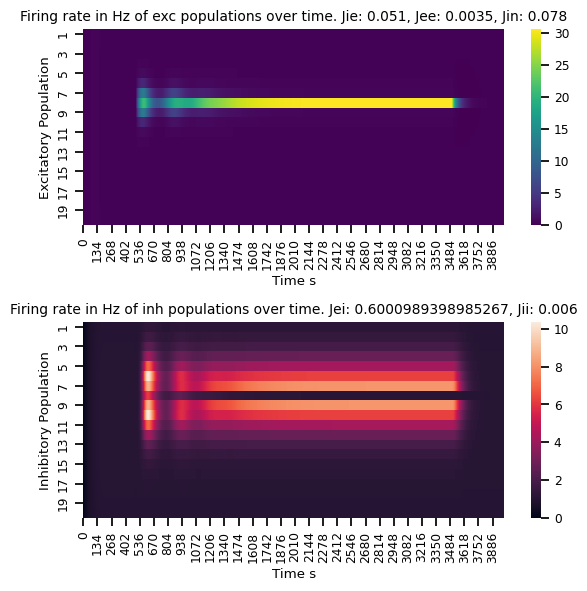

In [70]:
# call new model with other parameters

# +++++++++++++++++++++++++ Initialize the Model ++++++++++++++++++++++++++++
mymodel_otherInitialCondition = MyModel_otherInitialCondition()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sti = torch.tensor(stimuli.In, dtype=torch.float32)
r_e_otherInitialCondition, r_i_otherInitialCondition, dredt_otherInitialCondition, dridt_otherInitialCondition = mymodel_otherInitialCondition.forward(sti)

J2 = {'Jee': mymodel_otherInitialCondition.Jee.item(), 'Jei': mymodel_otherInitialCondition.Jei.detach().numpy(), 'Jie': mymodel_otherInitialCondition.Jie.detach().numpy(), 'Jii': mymodel.Jii.detach().numpy(),
       'Jin': mymodel_otherInitialCondition.Jin.detach().numpy()}
J_list2 = list(J2.keys())
#print(torch.max(r_e[1000,:]))
HeatMap(r_e_otherInitialCondition.detach().numpy(), r_i_otherInitialCondition.detach().numpy(), J2)

In [71]:
#SGD + Mean Loss
num_epochs = 10
lr = .00001

#param_new, losses_list,optimizer = optimizerloop(mymodel, X_input, Y_target, custom_loss_, "Adam",lr, num_epochs) # easyLoss #custom_loss_
param_new, losses_list,optimizer = optimizerloop(mymodel_otherInitialCondition, X_input, Y_target, custom_loss_0, "Adam",lr, num_epochs) # easyLoss #custom_loss_



7


ic| Cost_f: tensor(110613.5869, dtype=torch.float64, grad_fn=<AddBackward0>)


7


ic| Cost_f: tensor(110165.1867, dtype=torch.float64, grad_fn=<AddBackward0>)


7


ic| Cost_f: tensor(109723.0833, dtype=torch.float64, grad_fn=<AddBackward0>)


7


ic| Cost_f: tensor(109287.2689, dtype=torch.float64, grad_fn=<AddBackward0>)


7


ic| Cost_f: tensor(108857.6810, dtype=torch.float64, grad_fn=<AddBackward0>)


7


ic| Cost_f: tensor(108434.3275, dtype=torch.float64, grad_fn=<AddBackward0>)


7


ic| Cost_f: tensor(108017.1692, dtype=torch.float64, grad_fn=<AddBackward0>)


7


ic| Cost_f: tensor(107606.1671, dtype=torch.float64, grad_fn=<AddBackward0>)


7


ic| Cost_f: tensor(107201.3135, dtype=torch.float64, grad_fn=<AddBackward0>)


7


ic| Cost_f: tensor(106802.5379, dtype=torch.float64, grad_fn=<AddBackward0>)
ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0779, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(23413.8329, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0034, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(7282028.2779, dtype=torch.float64)


Epoch [10/10], Loss: 106802.53790279778, Loss_grad: <AddBackward0 object at 0x00000268660F5120>


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0511, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-243850.2339, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.4001, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-4531.7418, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0059, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(32454504.0550, dtype=torch.float64)


In [72]:

"""
*
*
***********  CLASS MYMODEL
*
*
"""


class MyModel_otherInitialCondition_training(nn.Module):
    def __init__(self):
        super(MyModel_otherInitialCondition_training, self).__init__()

        #--- Define other model parameters, layers, or components here if needed
        self.dt = torch.tensor(1e-4) #sim.dt
        self.N = 20
        self.taue = self.taui = torch.tensor(0.005)
         # ¤ parameter of the phi function Not tweakable parameters
        self.ae = torch.tensor(18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton
        self.be = torch.tensor(-5.38)  # Threshold of the E populaiton
        self.hme = torch.tensor(78.67)
        self.ai = torch.tensor(21.97)
        self.bi = torch.tensor(-4.81)
        self.hmi = torch.tensor(125.62)
        #create the smallest possible number
        self.epsilon = sys.float_info.epsilon

        self.sIn = torch.tensor(.1)
        self.sOut= 3.
        self.sEI = .2
        self.tauAMPA = torch.tensor(0.002)
        self.tauGABA = torch.tensor(0.005)

        self.wei = torch.tensor(dog_filter(self.sOut, int(self.N)), dtype=torch.float32)
        self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(self.sEI, int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  # Identity matrix

       
        #parameter random to test the optimization function
        self.Jee = nn.Parameter(torch.tensor(0.0779, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.0034, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.0511, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.4001, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.0059, requires_grad= True, dtype=torch.float64))

       
    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
        #multi= torch.nan_to_num((torch.mul(a, I_tot) + b), nan = self.epsilon, posinf=140, neginf=self.epsilon)
        for i in range(I_tot.shape[0]):
                if torch.isnan(I_tot[i])== True:
                    ic(I_tot, i)
                    quit()
                    sys.exit() #sys.

        mulAandI =torch.mul(a, I_tot)
        multiB= mulAandI + b
        expo = torch.exp(- (multiB))  #.abs()+ self.epsilon)
        return torch.multiply(hm, torch.divide(1, (1+ expo)))

    def forward(self, In):
        #--- Initialize model variables here
        prev_r_e = torch.zeros((In.shape[0], self.N)) # torch.ones(self.N) shows more obvious results
        prev_r_i = torch.zeros((In.shape[0], self.N))
        prev_s_ampa = torch.zeros((In.shape[0], self.N))
        prev_s_gaba = torch.zeros((In.shape[0], self.N))
        dr_e_dt = torch.zeros((In.shape[0], self.N))
        dr_i_dt = torch.zeros((In.shape[0], self.N))
        s_ampa = torch.tensor(0.)
        i_tot_e = torch.tensor(0.)
        i_tot_i = torch.tensor(0.)

        for k in range(1, In.shape[0]):
            #--- Compute values of interest
            #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
            s_gaba_wie = prev_s_gaba[k-1,:] @ self.wie
            s_ampa_wei = prev_s_ampa[k-1,:] @ self.wei
            s_gaba_wii = prev_s_gaba[k-1,:] @ self.wii
            JeeAmpa =  torch.mul(self.Jee, s_ampa)
            i_tot_e = torch.add(torch.subtract(JeeAmpa, torch.mul(self.Jie, s_gaba_wie)), torch.mul(self.Jin, In[k - 1, :]))
            i_tot_i = torch.subtract(torch.mul(self.Jei, s_ampa_wei), torch.mul(self.Jii, s_gaba_wii))

            phi_arr_e = self.phi(i_tot_e, self.ae, self.be, self.hme)
            phi_arr_i = self.phi(i_tot_i, self.ai, self.bi, self.hmi)

            dr_e_dt[k,:] = (-prev_r_e[k - 1, :] + phi_arr_e) / self.taue
            dr_i_dt[k,:] = (-prev_r_i[k - 1, :] + phi_arr_i) / self.taui

            r_e = prev_r_e[k - 1, :] + dr_e_dt[k,:] * self.dt
            r_i = prev_r_i[k - 1, :] + dr_i_dt[k,:] * self.dt

            dS_amp_dt = (- prev_s_ampa[k - 1, :] / self.tauAMPA) + r_e
            s_ampa = prev_s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- prev_s_gaba[k - 1, :] / self.tauGABA) + r_i
            s_gaba = prev_s_gaba[k - 1, :] + dS_gab_dt * self.dt

            prev_r_e[k,:] = r_e
            prev_r_i[k,:] = r_i
            prev_s_ampa[k,:] = s_ampa
            prev_s_gaba[k,:] = s_gaba

        return prev_r_e, prev_r_i, dr_e_dt, dr_i_dt

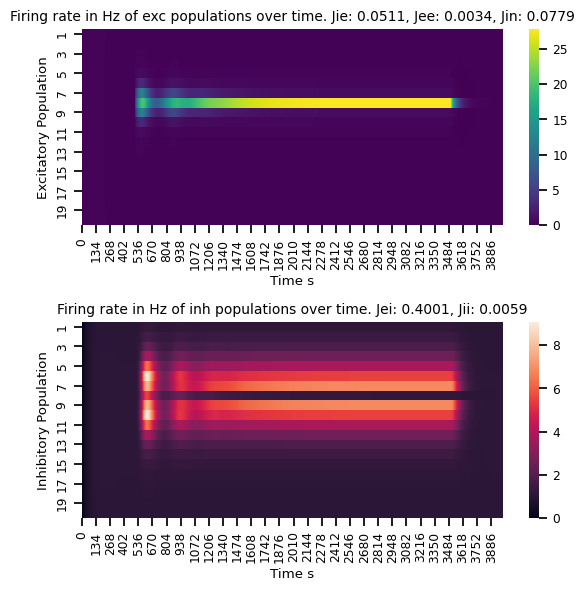

In [73]:
model4 = MyModel_otherInitialCondition_training()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sti = torch.tensor(stimuli.In, dtype=torch.float32)
r_e_4, r_i_4, dredt_4, dridt_4 = model4.forward(sti)

J4 = {'Jee': model4.Jee.item(), 'Jei': model4.Jei.detach().numpy(), 'Jie': model4.Jie.detach().numpy(), 'Jii': model4.Jii.detach().numpy(),
       'Jin': model4.Jin.detach().numpy()}
J_list2 = list(J4.keys())
#print(torch.max(r_e[1000,:]))
HeatMap(r_e_4.detach().numpy(), r_i_4.detach().numpy(), J4)



In [74]:
ic(mymodel.Jee, mymodel.Jei, mymodel.Jie, mymodel.Jii, mymodel.Jin)
ic(param_new)

"""
     Jee (0.0780, dtype=torch.float64, requires_grad=True)
   ic| J_list[i]: 'Jei'
         tensor(0.0035, dtype=torch.float64, requires_grad=True)
    J_list[i]: 'Jie'
         tensor(0.0510, dtype=torch.float64, requires_grad=True)
    J_list[i]: 'Jii'
         tensor(0.4000, dtype=torch.float64, requires_grad=True)
    J_list[i]: 'Jin'
         tensor(0.0061, dtype=torch.float64, requires_grad=True)
   """

ic| mymodel.Jee

: Parameter containing:
                 tensor(0.0719, dtype=torch.float64, requires_grad=True)
    mymodel.Jei: Parameter containing:
                 tensor(0.0039, dtype=torch.float64, requires_grad=True)
    mymodel.Jie: Parameter containing:
                 tensor(0.0501, dtype=torch.float64, requires_grad=True)
    mymodel.Jii: Parameter containing:
                 tensor(0.6001, dtype=torch.float64, requires_grad=True)
    mymodel.Jin: Parameter containing:
                 tensor(0.0069, dtype=torch.float64, requires_grad=True)
ic| param_new: [Parameter containing:
               tensor(0.0779, dtype=torch.float64, requires_grad=True),
                Parameter containing:
               tensor(0.0034, dtype=torch.float64, requires_grad=True),
                Parameter containing:
               tensor(0.0511, dtype=torch.float64, requires_grad=True),
                Parameter containing:
               tensor(0.4001, dtype=torch.float64, requires_grad=True),
               

"\n     Jee (0.0780, dtype=torch.float64, requires_grad=True)\n   ic| J_list[i]: 'Jei'\n         tensor(0.0035, dtype=torch.float64, requires_grad=True)\n    J_list[i]: 'Jie'\n         tensor(0.0510, dtype=torch.float64, requires_grad=True)\n    J_list[i]: 'Jii'\n         tensor(0.4000, dtype=torch.float64, requires_grad=True)\n    J_list[i]: 'Jin'\n         tensor(0.0061, dtype=torch.float64, requires_grad=True)\n   "

## Try to initial new model with trained parameters

In [75]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in mymodel_newParam.state_dict():
    print(param_tensor, "\t", mymodel_newParam.state_dict()[param_tensor])


# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
Jee 	 tensor(0.0719, dtype=torch.float64)
Jei 	 tensor(0.0039, dtype=torch.float64)
Jie 	 tensor(0.0501, dtype=torch.float64)
Jii 	 tensor(0.6001, dtype=torch.float64)
Jin 	 tensor(0.0069, dtype=torch.float64)
Optimizer's state_dict:
state 	 {0: {'step': tensor(10.), 'exp_avg': tensor(16230.0451, dtype=torch.float64), 'exp_avg_sq': tensor(6374559.6229, dtype=torch.float64)}, 1: {'step': tensor(10.), 'exp_avg': tensor(4873049.7419, dtype=torch.float64), 'exp_avg_sq': tensor(5.6507e+11, dtype=torch.float64)}, 2: {'step': tensor(10.), 'exp_avg': tensor(-182358.2063, dtype=torch.float64), 'exp_avg_sq': tensor(8.3770e+08, dtype=torch.float64)}, 3: {'step': tensor(10.), 'exp_avg': tensor(-2980.1065, dtype=torch.float64), 'exp_avg_sq': tensor(209578.2097, dtype=torch.float64)}, 4: {'step': tensor(10.), 'exp_avg': tensor(22297536.7712, dtype=torch.float64), 'exp_avg_sq': tensor(1.1977e+13, dtype=torch.float64)}}
param_groups 	 [{'lr': 1e-05, 'betas': (0.9, 0.999), 'eps': 1e

In [76]:
#Make a function which save parameters of trained model and upload the new model with the updated parameters

def model_with_saved_trained_param(old_model, optimizer, Model):
    # or to save the parameters only
    torch.save(old_model.state_dict(),"Old_model_optimized_parameters.pth")
    torch.save(optimizer.state_dict(),"optimizer_optimized_parameters.pth")
    #load these parameters in a new model instance
    new_mymodel = Model()
    new_mymodel.load_state_dict(torch.load("Old_model_optimized_parameters.pth")) 
    optimizer.load_state_dict(torch.load('optimizer_optimized_parameters.pth'))

    print(optimizer.param_groups[0]['params'])
    print("old model",mymodel.Jee,"new model", new_mymodel.Jee)
    #print(optimizer.param_groups)
    #print(optimizer.state)
    return new_mymodel

model_with_saved_trained_param(mymodel, optimizer, MyModel_newParam)


[Parameter containing:
tensor(0.0779, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(0.0034, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(0.0511, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(0.4001, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(0.0059, dtype=torch.float64, requires_grad=True)]
old model Parameter containing:
tensor(0.0719, dtype=torch.float64, requires_grad=True) new model Parameter containing:
tensor(0.0719, dtype=torch.float64, requires_grad=True)


MyModel_newParam()

In [77]:
# to save the entire model
#torch.save(mymodel, "trained_model_1.pth")

#load the model
#loaded_model = torch.load("trained_model_1.pth")

# or to save the parameters only
torch.save(mymodel.state_dict(),"mymodel_parameters_1_randomInitalParam.pth")
torch.save(optimizer.state_dict(),"mymodel_optimizer_parameters_1_randomInitalParam.pth")
#load these parameters in a new model instance
new_mymodel_param1 = MyModel_time()

new_mymodel_param1.load_state_dict(torch.load("mymodel_parameters_1_randomInitalParam.pth")) 
optimizer.load_state_dict(torch.load('mymodel_optimizer_parameters_1_randomInitalParam.pth'))

print(optimizer.param_groups[0]['params'])
print("old model",mymodel.Jee,"new model", new_mymodel_param1.Jee)
print(optimizer.param_groups)
print(optimizer.state)


param_new2, losses_list2,optimizer2 = optimizerloop(new_mymodel_param1, X_input, Y_target, custom_loss_0, "Adam",lr, 3) # easyLoss #custom_loss_

# Save optimizer weights.
"""
mymodel.save_weights('weights.h5')
symbolic_weights = getattr(mymodel.optimizer, 'weights')
weight_values = K.batch_get_value(symbolic_weights)

if symbolic_weights:
    optimizer_weights_group = f.create_group('optimizer_weights')
    weight_values = K.batch_get_value(symbolic_weights)"""

[Parameter containing:
tensor(0.0779, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(0.0034, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(0.0511, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(0.4001, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(0.0059, dtype=torch.float64, requires_grad=True)]
old model Parameter containing:
tensor(0.0719, dtype=torch.float64, requires_grad=True) new model Parameter containing:
tensor(0.0719, dtype=torch.float64, requires_grad=True)
[{'lr': 1e-05, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [Parameter containing:
tensor(0.0779, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(0.0034, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(0.0511, dtype=torch.float64, requires_grad=T

ic| Cost_f: tensor(170698.3551, dtype=torch.float64, grad_fn=<AddBackward0>)


7


ic| Cost_f: tensor(169416.0423, dtype=torch.float64, grad_fn=<AddBackward0>)


7


ic| Cost_f: tensor(168151.7608, dtype=torch.float64, grad_fn=<AddBackward0>)
ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0719, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(87802.6721, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0039, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(26650468.3863, dtype=torch.float64)


Epoch [3/3], Loss: 168151.7607969448, Loss_grad: <AddBackward0 object at 0x000002680D9ADCC0>


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0501, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-1568503.3761, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6001, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-19537.3156, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0068, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(97279781.8975, dtype=torch.float64)


"\nmymodel.save_weights('weights.h5')\nsymbolic_weights = getattr(mymodel.optimizer, 'weights')\nweight_values = K.batch_get_value(symbolic_weights)\n\nif symbolic_weights:\n    optimizer_weights_group = f.create_group('optimizer_weights')\n    weight_values = K.batch_get_value(symbolic_weights)"

In [78]:
new_mymodel_param1.eval()

"""Y_prediction, I, dredt, dridt = mymodel.forward(X_input)
rameter containing:
               tensor(0.0779, dtype=torch.float64, requires_grad=True),
                Parameter containing:
               tensor(0.0034, dtype=torch.float64, requires_grad=True),
                Parameter containing:
               tensor(0.0511, dtype=torch.float64, requires_grad=True),
                Parameter containing:
               tensor(0.4001, dtype=torch.float64, requires_grad=True),
                Parameter containing:
               tensor(0.0059, 
HeatMap(r_e, )"""

'Y_prediction, I, dredt, dridt = mymodel.forward(X_input)\nrameter containing:\n               tensor(0.0779, dtype=torch.float64, requires_grad=True),\n                Parameter containing:\n               tensor(0.0034, dtype=torch.float64, requires_grad=True),\n                Parameter containing:\n               tensor(0.0511, dtype=torch.float64, requires_grad=True),\n                Parameter containing:\n               tensor(0.4001, dtype=torch.float64, requires_grad=True),\n                Parameter containing:\n               tensor(0.0059, \nHeatMap(r_e, )'

In [79]:
new_mymodel_param1.Jii

Parameter containing:
tensor(0.6001, dtype=torch.float64, requires_grad=True)

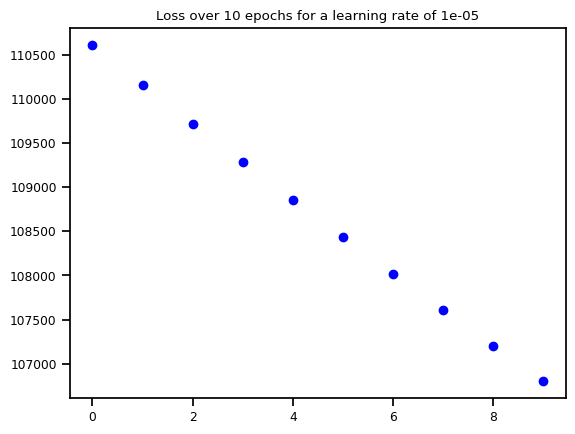

In [80]:
plt.plot(np.arange(losses_list.shape[0]), losses_list.detach().numpy(), 'bo', label='Training loss')
plt.title(f"Loss over {num_epochs} epochs for a learning rate of {lr}")
plt.show()

In [81]:
"""
*
*  OPTIMIZATION PART
*
*
"""

# +++++++++++++++++++++++++ Optimizer ++++++++++++++++++++++++++++
learning_rate = 0.00001 #0.001
optimizer = optim.SGD(mymodel.parameters(),
                      lr=learning_rate, weight_decay = 0.0001)#, weight_decay = 0.00001) #, weight_decay = 0.00001)#, weight_decay = 0.001)#0.989



# +++++++++++++++++++++++++ Epochs +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
num_epochs = 5

# +++++++++++++++++++++++++ Inputs + Labels +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
X_input = sti
Y_target = get_expected_Y_relu(X_input) #get the expected dirac delta for our particular Input
losses = torch.zeros(num_epochs) # used to plot the loss at the end

# +++++++++++++++++++++++++ Problems investigations +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# import tracemalloc
# tracemalloc.start()
mymodel.train()
criterion = nn.CrossEntropyLoss()#.cuda()

# +++++++++++++++++++++++++ Optimization loop +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
with torch.autograd.set_detect_anomaly(False):
    for epoch in range(num_epochs):
        # Create a new input tensor for each epoch
        #X_input.requires_grad = False
        # Clear the gradients
        optimizer.zero_grad()

        # calculate output
        Y_prediction, I, dredt, dridt = mymodel(X_input)
        #ic(Y_prediction.grad_fn)

        # calculate loss
        Y_prediction_prob = make_it_proba(Y_prediction)
        #loss = torch.sum(torch.sum((Y_prediction_prob-Y_target), axis =1))# (torch.mean((Y_prediction_prob - Y_target)**2))
        loss = criterion(Y_prediction_prob, Y_target) #t

        #ic(loss.grad_fn)

        loss.backward()

        #torch.nn.utils.clip_grad_norm_(mymodel.parameters(), -5, 5)  # Adjust max_norm as needed

        optimizer.step()

        losses[epoch] = loss
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss}, Loss_grad: {loss.grad_fn}')  # .item()
        for i, par in enumerate(mymodel.parameters()):
           ic(J_list[i], par, par.grad)






# check if input has zeros
#torch.all(losses) # return True if there are zeros, otherwise return False

# check if input has nans
#torch.any(torch.isnan(losses)) # return True if there are nans, otherwise return False


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0719, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0650, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0040, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-7.7876, dtype=torch.float64

Epoch [1/5], Loss: 2.3717362880706787, Loss_grad: <DivBackward1 object at 0x000002680D14DA80>


)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0501, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.4858, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6001, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0103, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0071, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-27.7298, dtype=torch.float64)
ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0719, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0486, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0040, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-4.4676, dtype=torch.float64)


Epoch [2/5], Loss: 2.36535382270813, Loss_grad: <DivBackward1 object at 0x00000268660F5120>


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0501, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.4588, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6001, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0058, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0073, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-16.0940, dtype=torch.float64)
ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0719, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0419, dtype=torch.float64)


Epoch [3/5], Loss: 2.3629543781280518, Loss_grad: <DivBackward1 object at 0x00000268660F5120>


ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0041, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-3.4368, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0501, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.4501, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6001, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0042, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0074, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-11.7315, dtype=torch.float64)
ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0719, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0377, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0041, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-2.8983, dtype=torch.f

Epoch [4/5], Loss: 2.3616199493408203, Loss_grad: <DivBackward1 object at 0x00000268660F5120>


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0501, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.4451, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6001, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0032, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0075, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-9.2111, dtype=torch.float64)
ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0719, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0348, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0041, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-2.5581, dtype=torch.float64)
ic| J_list[i]

Epoch [5/5], Loss: 2.3607704639434814, Loss_grad: <DivBackward1 object at 0x00000268660F5120>


: 'Jie'
    par: Parameter containing:
         tensor(0.0501, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.4416, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6001, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0025, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0076, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-7.5193, dtype=torch.float64)


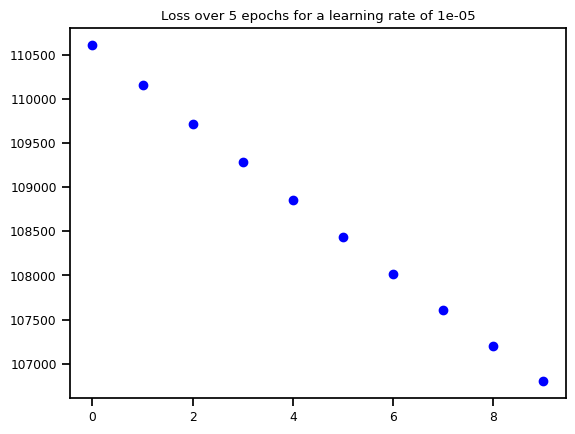

In [82]:
"""
*
*  Plot the loss over epochs
*
"""

plt.plot(np.arange(losses_list.shape[0]), losses_list.detach().numpy(), 'bo', label='Training loss')

plt.title(f"Loss over {num_epochs} epochs for a learning rate of {learning_rate}")
plt.show()
